In [1]:
%matplotlib inline
# math libs
import math
import numpy as np
from scipy.spatial import distance
from scipy.spatial import ConvexHull

# plotting libs
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from mpl_toolkits.mplot3d import Axes3D

import random

In [2]:
def parse_points(points):
    X = [elem[0] for elem in points]
    Y = [elem[1] for elem in points]
    Z = [elem[2] for elem in points]
    return X, Y, Z

def gen_random_point(dim, lower=-1e1, upper=1e1):
    return [random.uniform(lower, upper) for i in range(dim)]

def get_surface(point, surf, border, step=0.025):
    if surf == 'x':
        y = np.arange(border[0], border[1], step) 
        stp = (border[3] - border[2]) / len(y)
        z = np.arange(border[2], border[3], stp) 
        y, z = np.meshgrid(y, z)
        x = np.ones(len(y)) * point[0]
        return x, y, z

    if surf == 'y':
        x = np.arange(border[0], border[1], step)
        stp = (border[3] - border[2]) / len(x)
        z = np.arange(border[2], border[3], stp) 
        x, z = np.meshgrid(x, z)
        y = np.ones(len(x)) * point[1]
        return x, y, z
        
    if surf == 'z':
        x = np.arange(border[0], border[1], step) 
        stp = (border[3] - border[2]) / len(x)
        y = np.arange(border[2], border[3], stp) 
        x, y = np.meshgrid(x, y)
        z = np.ones(len(x)) * point[2]
        return x, y, z

In [3]:
class Algorithm:
    x = []
    
    def __init__(self, points, weights):
        self.p = points
        self.w = weights
        
    def solve(self, x_0, epsilon): ...
        
    def T(self, point):
        for i in range(len(self.p)):
            if np.array_equal(point, self.p[i]):
                return self.p[i]

        numerator = 0.
        denominator = 0.
        
        for j in range(len(point)):
            norm = distance.euclidean(point, self.p[j])
            
            numerator = numerator + self.w[j] * self.p[j] / norm
            denominator = denominator + self.w[j] / norm

        return numerator / denominator

### A projected Weiszfeld algorithm for the box-constrained Weber location problem

Let $a_1, ... , a_m$ be m pointas in the space $R^n$ (vertices) and positive numbers $w_1, ... ,w_m$ weights.

In [4]:
a = np.array([        
        np.array([1,-1,1]),
        np.array([1,-1,-1]),
        np.array([1,1,1]),
        np.array([1,1,-1]),
        np.array([-1,1,1]),
        np.array([-1,1,-1]),
        np.array([-1,-1,1]),
        np.array([-1,-1,-1]),
        np.array([1.5,0,0]),
        np.array([-1.5,0,0]),
        np.array([0,1.5,0]),
        np.array([0,-1.5,0]),
        np.array([0,0,1.5]),
        np.array([0,0,-1.5])
    ])

In [5]:
w = np.array([random.randint(1, 1e1) for i in range(len(a))])
w

array([ 6,  9,  6, 10,  1,  9,  3,  8,  3,  9,  4,  1,  8,  2])

### Algorithm 1. Weiszfeld algorithm

##### Step 1

Compute: $$x^{(k+1)} = T(x^{(k)})$$

##### Step 2

Stop execution if 

$$\lVert x^{(k+1)} - x^{(k)} \rVert < \varepsilon $$


In [6]:
class Weiszfeld(Algorithm):
    
    def solve(self, x_0, epsilon=1e-5):
        before_x = x_0
        next_x = self.T(before_x)
        self.x = [before_x, next_x]

        while distance.euclidean(next_x, before_x) >= epsilon:
            tmp = next_x
            next_x = self.T(before_x)
            before_x = tmp
            
            self.x.append(next_x)

In [7]:
wsfd = Weiszfeld(a, w)
wsfd.solve(np.array([2,2,2]), 1e-10)
points = wsfd.x
points

[array([2, 2, 2]),
 array([ 1.        , -0.05583442,  0.43723997]),
 array([ 1.        , -0.05583442,  0.43723997])]

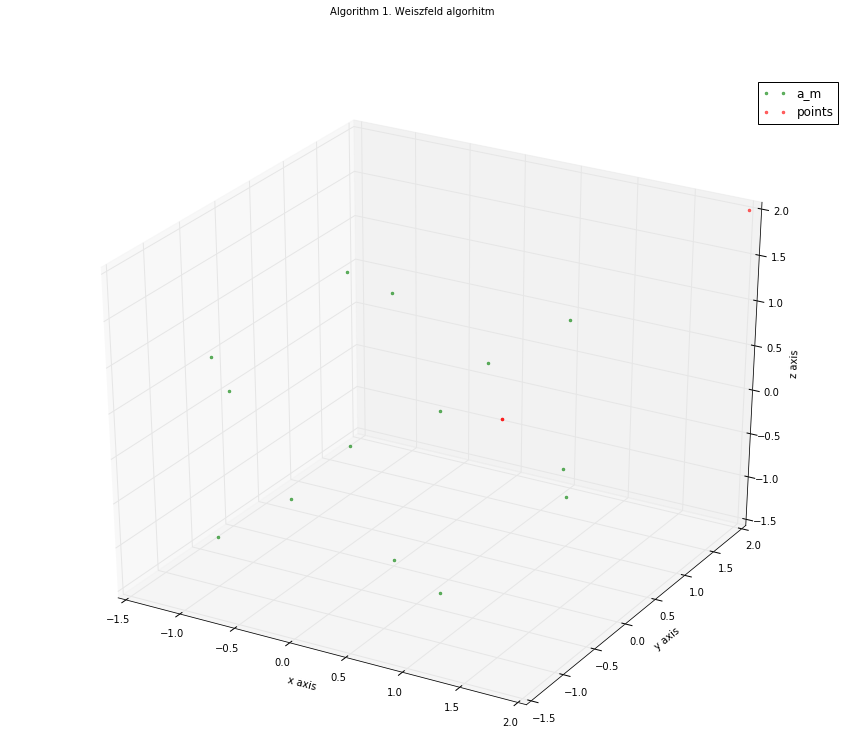

In [8]:
figure = plt.figure(figsize=(15,12))
ax = figure.gca(projection='3d')

pp = parse_points(a)
ax.plot(pp[0], pp[1], pp[2], 'g.', alpha=0.6)

pp = parse_points(points)
ax.plot(pp[0], pp[1], pp[2], 'r.', alpha=0.6)

ax.set_xlabel('x axis')
ax.set_ylabel('y axis')
ax.set_zlabel('z axis')
figure.suptitle('Algorithm 1. Weiszfeld algorhitm')
ax.legend(['a_m', 'points'])

### Algorithm 2. Projected Weiszfeld algorithm

Given $l, u \in R^n$ define $\Omega = \{ x \in R^n : l \leq x \leq u \}$. Assume that $x^{(0)} \in \Omega - \{a_1,...,a_m\}$ is an initial approximations  tolerance. Given $x^{(k)} \in \Omega$ do the following steps to compute $x^{(k+1)}$

##### Step 1

Compute: $$x^{(k+1)}_T = T(x^{(k)})$$

##### Step 2

Project onto the box $\Omega$ 

$$ x^{(k+1)} = P(x^{(k)}_T)$$

##### Step 3

Stop the execution if

$$\lVert x^{(k+1)} - x^{(k)} \rVert < \varepsilon $$

and declare $x^{(k+1)}$ as solution to the problem $argmin$ $f(x)$ (where f is called the Weber function).


In [9]:
class Projected_Weiszfeld(Algorithm):
    l = []
    u = []
    
    def __init__(self, points, weights):
        super().__init__(points, weights)
        self.l = gen_random_point(len(points[0]), -5, 0)
        self.u = gen_random_point(len(points[0]), 0, 5)
    
    def _P(self, point): 
        ans = point
        
        for i in range(len(point)):
            if point[i] < self.l[i]:
                ans[i] = self.l[i]
            if point[i] > self.u[i]:
                ans[i] = self.u[i]
                
        return ans
    
    def solve(self, x_0, epsilon=1e-5):
        before_x = x_0
        next_x = self.T(x_0)
        
        self.x = [before_x, next_x]

        while distance.euclidean(next_x, before_x) >= epsilon:
            tmp = next_x
            next_x = self._P(self.T(before_x))
            before_x = tmp
            self.x.append(next_x)

In [10]:
prj_wsfd = Projected_Weiszfeld(a, w)
prj_wsfd.solve(np.array([2,2,2]), 1e-10)
points, l, u = prj_wsfd.x, prj_wsfd.l, prj_wsfd.u
print(len(points))
print(points[-1])
print('u -', u)
print('l -', l)

3
[ 1.         -0.05583442  0.43723997]
u - [3.111573019825504, 3.879356023720966, 4.819648912660501]
l - [-4.912849577444497, -0.8364024328748245, -2.688093169857577]


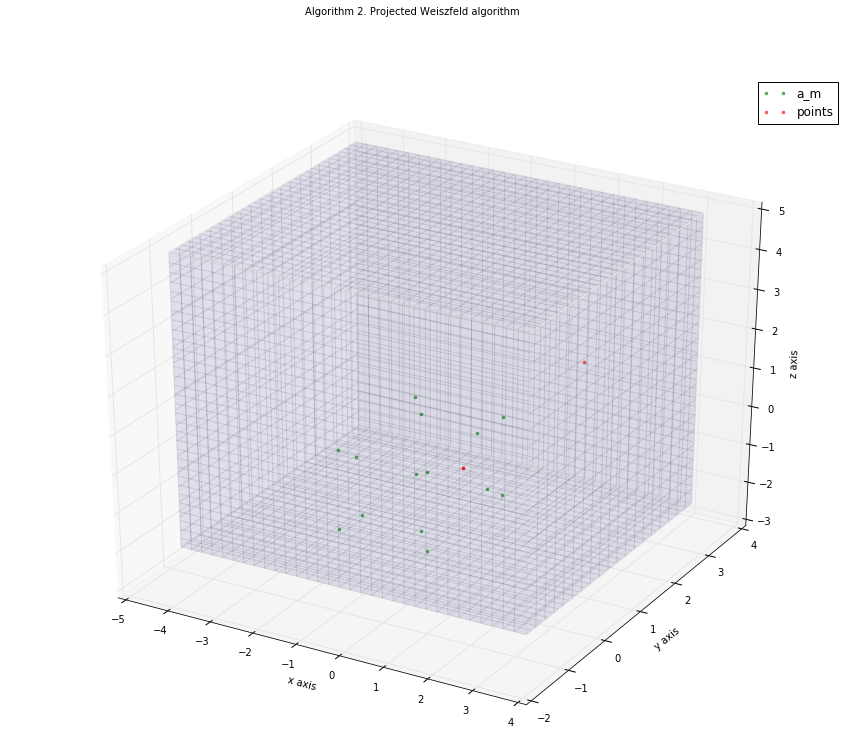

In [11]:
figure = plt.figure(figsize=(15,12))
ax = figure.gca(projection='3d')

pp = parse_points(a)
ax.plot(pp[0], pp[1], pp[2], 'g.', alpha=0.6)

pp = parse_points(points)
ax.plot(pp[0], pp[1], pp[2], 'r.', alpha=0.6)

# borders
srf_alpha = 0.05
x, y, z = get_surface(u, 'x', (l[1], u[1], l[2], u[2]))
ax.plot_surface(x, y, z, color='b', alpha=srf_alpha)

x, y, z = get_surface(u, 'y', (l[0], u[0], l[2], u[2]))
ax.plot_surface(x, y, z, color='b', alpha=srf_alpha)

x, y, z = get_surface(u, 'z', (l[0], u[0], l[1], u[1]))
ax.plot_surface(x, y, z, color='b', alpha=srf_alpha)

x, y, z = get_surface(l, 'x', (l[1], u[1], l[2], u[2]))
ax.plot_surface(x, y, z, color='b', alpha=srf_alpha)

x, y, z = get_surface(l, 'y', (l[0], u[0], l[2], u[2]))
ax.plot_surface(x, y, z, color='b', alpha=srf_alpha)

x, y, z = get_surface(l, 'z', (l[0], u[0], l[1], u[1]))
ax.plot_surface(x, y, z, color='b', alpha=srf_alpha)


ax.set_xlabel('x axis')
ax.set_ylabel('y axis')
ax.set_zlabel('z axis')
figure.suptitle('Algorithm 2. Projected Weiszfeld algorithm')
ax.legend(['a_m', 'points'])

### Tests

In [12]:
def dimension_test():
    X = range(2, 10)
    wsf_len = []
    prj_wsf_len = []
    
    for i in X:
        m = random.randint(50, 100)
        weights = [random.randint(-100, 100) for i in range(m)]
        
        points = np.random.rand(m, i)
        hull = ConvexHull(points)
        points = [np.array(points[index]) for index in hull.vertices]
        
        rand_point = gen_random_point(i, 
                                      random.randint(-100, 0), random.randint(0, 100))
        
        wsfd = Weiszfeld(points, weights)
        wsfd.solve(rand_point, 1e-10)

        prj_wsfd = Projected_Weiszfeld(points, weights)
        prj_wsfd.solve(rand_point, 1e-10)

        wsf_len.append(len(wsfd.x)) 
        prj_wsf_len.append(len(prj_wsfd.x))
        
    return X, wsf_len, prj_wsf_len

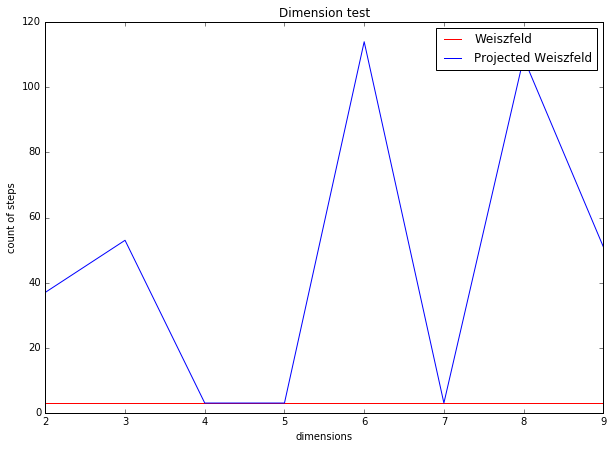

In [13]:
x, wsf, pwsf = dimension_test()

plt.figure(figsize=(10, 7))
plt.title("Dimension test")
plt.plot(x, wsf, 'r')
plt.plot(x, pwsf, 'b')
plt.xlabel("dimensions")
plt.ylabel("count of steps")
plt.legend(["Weiszfeld", "Projected Weiszfeld"])

In [14]:
def points_test():
    X = range(10)
    wsf_len = []
    prj_wsf_len = []
    
    for i in X:
        m = random.randint(500, 1000)
        weights = [random.randint(-100, 100) for i in range(m)]
        
        # np.random.rand(m, 3) - generate m points in 3 dimension 
        points = np.random.rand(m, 3)
        hull = ConvexHull(points)
        points = [np.array(points[index]) for index in hull.vertices]
        
        rand_point = gen_random_point(3, 
                                      random.randint(-10, -1), random.randint(1, 10))
        
        wsfd = Weiszfeld(points, weights)
        wsfd.solve(rand_point, 1e-10)

        prj_wsfd = Projected_Weiszfeld(points, weights)
        prj_wsfd.solve(rand_point, 1e-10)

        wsf_len.append(len(wsfd.x)) 
        prj_wsf_len.append(len(prj_wsfd.x))
        
    return X, wsf_len, prj_wsf_len

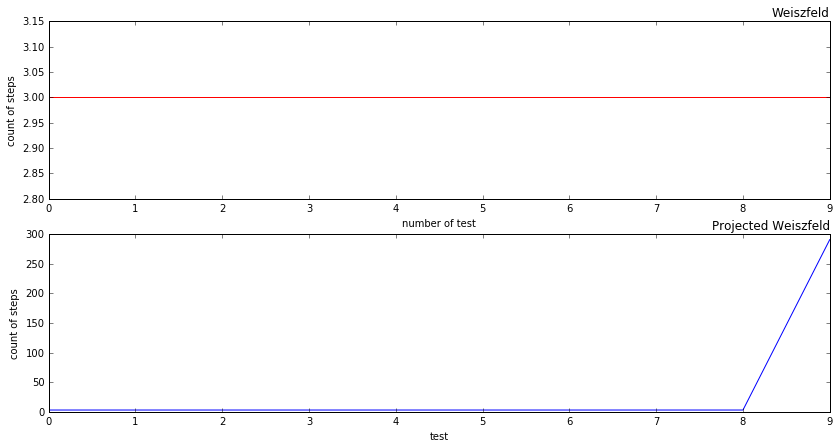

In [15]:
x, wsf, pwsf = points_test()

plt.figure(figsize=(14, 7))

plt.subplot(211)
plt.plot(x, wsf, 'r')
plt.title("Weiszfeld", loc='right')
plt.xlabel("number of test")
plt.ylabel("count of steps")

plt.subplot(212)
plt.plot(x, pwsf, 'b')
plt.title("Projected Weiszfeld", loc="right")
plt.xlabel("test")
plt.ylabel("count of steps")